In [1]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from process_data import *
from models.transformer_cnn import *
from training import train
from evaluation import evaluate
import matplotlib.pyplot as plt

In [2]:
df_zoo_train, df_zoo_test = load_data("../data")
df_zoo_train.head()

,Record_id,Attribute_name,y_act,total_vals,num_nans,%_nans,num_of_dist_val,%_dist_val,mean,std_dev,...,mean_stopword_total,stdev_stopword_total,mean_char_count,stdev_char_count,mean_whitespace_count,stdev_whitespace_count,mean_delim_count,stdev_delim_count,is_list,is_long_sentence
0,33,Area,categorical,21477,0,0.0,174,0.810169,0.000000,0.000000,...,0.2,0.4,10.0,4.816638,0.4,0.8,0.4,0.8,False,False
1,33,Area Code,categorical,21477,0,0.0,174,0.810169,125.449411,72.866452,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,False,False
2,33,Element,categorical,21477,0,0.0,2,0.009312,0.000000,0.000000,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
3,33,Element Code,categorical,21477,0,0.0,2,0.009312,5211.687154,146.816661,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
4,33,Item,categorical,21477,0,0.0,115,0.535457,0.000000,0.000000,...,0.8,0.4,19.6,2.244994,2.0,0.0,2.0,0.0,False,False


In [3]:
train_data = preprocess(df_zoo_train)
test_data = preprocess(df_zoo_test)
train_data.head()

,text,features,label
0,Area [SEP] Afghanistan [SEP] Albania [SEP] Alg...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
1,Area Code [SEP] 2 [SEP] 3 [SEP] 4 [SEP] 7 [SEP] 8,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
2,Element [SEP] Food [SEP] Feed [SEP] Food [SEP]...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
3,Element Code [SEP] 5142 [SEP] 5521 [SEP] 5142 ...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
4,Item [SEP] Wheat and products [SEP] Rice (Mill...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0


In [4]:
x_train, x_val, y_train, y_val = train_test_split(train_data[['text', "features"]], train_data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_data['label'])

In [5]:
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model_name = "bert_cnn_v1"

In [7]:
device = torch.device("cuda")

In [8]:
for param in bert.parameters():
    param.requires_grad = False

In [9]:
train_dataloader, val_dataloader, test_dataloader = init_dataloaders(x_train, y_train, x_val, y_val, 
                                                                     test_data, model="bert")

/home/tamittal/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
class BERT_cnn(nn.Module):

    def __init__(self, bert, num_kernels, kernel_sizes):

        super(BERT_cnn, self).__init__()

        self.bert = bert 
    
        Co = num_kernels
        Ks = kernel_sizes
        
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, 768)) for K in Ks])
        self.dropout = nn.Dropout(0.1)
          
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(len(Ks) * Co + 19, 9)
        
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, features):

        #pass the inputs to the model 
        bert_out = self.bert(sent_id, attention_mask=mask)
        
        x = bert_out.last_hidden_state
        
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        
        x = torch.cat(x, 1)
        
        x = torch.cat([x, features], 1)
        
        x = self.dropout(x)  
        
        x = self.fc1(x)  
        
        x = self.softmax(x)

        return x

In [11]:
model = BERT_cnn(bert, 512, [1, 2, 3, 4, 5, 6, 7, 8, 9])

model = model.to(device)

In [12]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("Class Weights:",class_weights)

Class Weights: [0.3034519  0.47585845 1.64387464 3.05291005 7.66545894 1.88059259
 4.63961988 1.00890161 1.25261496]


/home/tamittal/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8.], y=7476    6.0
1834    1.0
7213    5.0
500     0.0
1015    7.0
       ... 
2251    0.0
3105    2.0
5948    8.0
1403    1.0
357     0.0
Name: label, Length: 6347, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [14]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

In [20]:
# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)
# number of training epochs
epochs = 25

In [21]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _, = train(model, train_dataloader, optimizer, cross_entropy)
    
    #evaluate model
    valid_loss, _, valid_acc = evaluate(model, val_dataloader, cross_entropy, y_val)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../models/exports/%s.pt' % model_name)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.154
Validation Loss: 0.267
Validation Accuracy: 0.904

 Epoch 2 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.151
Validation Loss: 0.266
Validation Accuracy: 0.900

 Epoch 3 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.147
Validation Loss: 0.265
Validation Accuracy: 0.900

 Epoch 4 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.161
Validation Loss: 0.264
Validation Accuracy: 0.904

 Epoch 5 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.149
Validation Loss: 0.265
Validation Accuracy: 0.905

 Epoch 6 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evalua

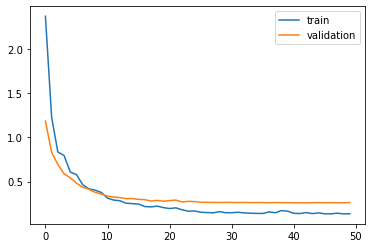

In [22]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train", "validation"])

In [23]:
loss, preds, acc = evaluate(model,test_dataloader, cross_entropy, test_data["label"])
print("test_accuracy:", acc)


Evaluating...
  Batch    50  of     63.
test_accuracy: 0.9073047858942066
